### Goal: we analyze the predictive power of the SMA and RSI indicators for the n-day return

SMA (simple moving average) is the unweighted mean of the previous $n$ data points. In other words, $p_{SM} = \frac{X_m + X_{m-1} + \dots, X_{m-(n-1)}}{n}$. 

RSI (Relative strngth index) is an indicator measuing the velocity and magnitude of price movements. The calculation of RSI follows the following formulas: 
$$RSI = 100 - \frac{100}{1+RS},$$
where $$RS = \frac{[(\text{previous average gain})\times (m-1) + \text{current gain}]/m}{[(\text{previous average loss})\times (m-1) + \text{current loss}]/m}$$ and
an average gain and average loss is taken over some number $n$ of RSI periods. 

Both, SMA and RSI are used to build signals to buy and sell securities: SMA is used for momentum strategies and RSI for mean-reversion strategies. 

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm

In [25]:
#Sourcing data from yahoo finance
all_data = {}
for ticker in ['AAPL', 'IBM']:
    all_data[ticker] = web.get_data_yahoo(ticker, '1/1/2000')

In [45]:
df_aapl = all_data['AAPL'][['Adj Close']]
df_ibm = all_data['IBM'][['Adj Close']]

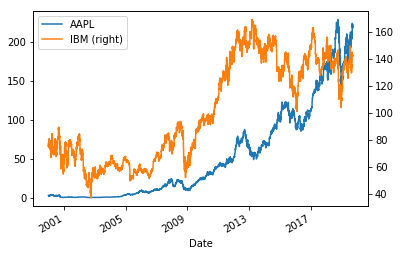

<Figure size 432x288 with 0 Axes>

In [7]:
#plotting the prices
df_aapl['Adj Close'].plot(label='AAPL', legend=True)
df_ibm['Adj Close'].plot(label='IBM', legend=True, secondary_y=True)
plt.show()
plt.clf()

In [87]:
def add_rsi_sma_to_data(df):
    """input: prices data frame
    output: 
    a) data frame enlarged with: 
    - future and current 5-day return 
    - sma and rsi features for different n timeperiods
    b) features names
    c) target"""
    df_ext = df.copy()
    df_ext.loc[:, '5d_fut_close']= df['Adj Close'].shift(-5)
    df_ext.loc[:, '5d_fut_close_pct'] = df_ext['5d_fut_close'].pct_change(5)
    df_ext.loc[:, '5d_close_pct'] = df['Adj Close'].pct_change(5)
    
    feature_names = ['5d_close_pct']
    target_name = ['5d_fut_close_pct']
              
    for n in [14,30,50,200]:
        df_ext.loc[:, 'ma' + str(n)] = talib.SMA(df['Adj Close'].values,
                                                timeperiod=n)/df['Adj Close']
        df_ext.loc[:, 'rsi'+str(n)] = talib.RSI(df['Adj Close'].values,
                                               timeperiod=n)
        feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
    feat_targ_name = feature_names + target_name
    
    #drop na from df_ext
    df_ext = df_ext.dropna()
    
    return (df_ext, feature_names, target_name, feat_targ_name) 

In [88]:
#Set an extended data frame for Apple
(aapl_ext, aapl_feat, aapl_targ, feat_targ) = add_rsi_sma_to_data(df_aapl)

### Correlation

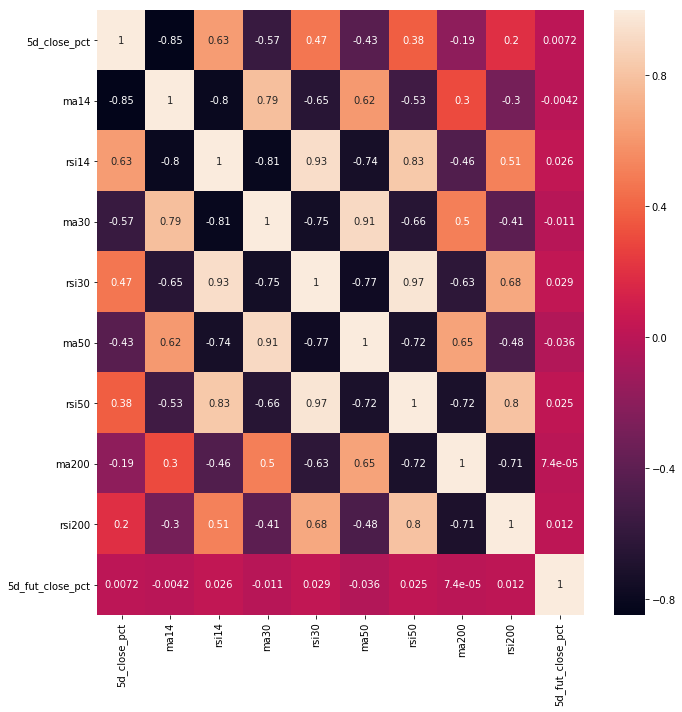

<Figure size 432x288 with 0 Axes>

In [91]:
#calculate correlation matrix
corr = aapl_ext[feat_targ].corr()

#plot heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90) # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

We notice that correlation between our features and 5-day future return is not very large. The largest correlation is with rsi30. We will build a scatter plot to see how good this correlation is. 

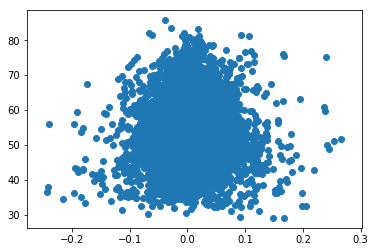

In [94]:
# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(aapl_ext['5d_fut_close_pct'], aapl_ext['rsi30'])
plt.show()


#We see that the relation is quite weak

### Linear regression model

In [101]:
features = aapl_ext[aapl_feat]
targets = aapl_ext[aapl_targ]

In [102]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(4757, 10) (4043, 10) (714, 10)


In [105]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
#print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)
print("Rsquared: ",results.rsquared)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

const           0.101836
5d_close_pct    0.819138
ma14            0.940598
rsi14           0.457631
ma30            0.000033
rsi30           0.688725
ma50            0.000002
rsi50           0.663310
ma200           0.001478
rsi200          0.620377
dtype: float64
Rsquared:  0.008937017748833487


Overview of the results: Rsquares is quite small, and only coefficients wrt ma30, ma50 and ma200 are significantly different from 0

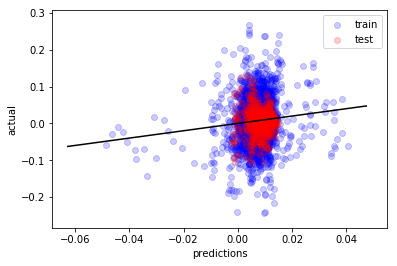

In [106]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()